## Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import * 
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

os.chdir("")



import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# from numpy.random import seed
# np.seed(1) #Seed function is used to save the state of random function
# from tensorflow import set_random_seed
# np.set_random_seed(1)

## Read List of artists and paintins from csv

In [2]:
artists = pd.read_csv('artists.csv')
artists.shape

(50, 8)

In [3]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
id             50 non-null int64
name           50 non-null object
years          50 non-null object
genre          50 non-null object
nationality    50 non-null object
bio            50 non-null object
wikipedia      50 non-null object
paintings      50 non-null int64
dtypes: int64(2), object(6)
memory usage: 3.2+ KB


###  Drop Less informative columns

In [4]:
artists.drop(["id","bio","wikipedia"],axis=1,inplace=True)
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
name           50 non-null object
years          50 non-null object
genre          50 non-null object
nationality    50 non-null object
paintings      50 non-null int64
dtypes: int64(1), object(4)
memory usage: 2.1+ KB


In [5]:
#https://en.wikipedia.org/wiki/Digital_image_processing
#Adding some more col as part of data preprocessing
# Sort artists by number of paintings
# above code shows "painting" feature so as to group paintings to respecting painting.
artists = artists.sort_values(by=['paintings'], ascending=False)
# Create a dataframe with artists having more than 20 paintings
artists_top = artists[artists['paintings'] >= 20].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

name  paintings  class_weight
0            Vincent van Gogh        877      0.192611
1                 Edgar Degas        702      0.240627
2               Pablo Picasso        439      0.384784
3       Pierre-Auguste Renoir        336      0.502738
4              Albrecht Dürer        328      0.515000
5                Paul Gauguin        311      0.543151
6              Francisco Goya        291      0.580481
7                   Rembrandt        262      0.644733
8               Alfred Sisley        259      0.652201
9                      Titian        255      0.662431
10               Marc Chagall        239      0.706778
11              Rene Magritte        194      0.870722
12          Amedeo Modigliani        193      0.875233
13                  Paul Klee        188      0.898511
14              Henri Matisse        186      0.908172
15                Andy Warhol        181      0.933260
16             Mikhail Vrubel        171      0.987836
17          Sandro Botticelli        164      1.030000
18          Leonardo da Vinci        143      1.181259
19          Peter Paul Rubens        141      1.198014
20              Salvador Dali        139      1.215252
21           Hieronymus Bosch        137      1.232993
22             Pieter Bruegel        134      1.260597
23            Diego Velazquez        128      1.319687
24           Kazimir Malevich        126      1.340635
25                Frida Kahlo        120      1.407667
26          Giotto di Bondone        119      1.419496
27               Gustav Klimt        117      1.443761
28                    Raphael        109      1.549725
29                  Joan Miro        102      1.656078
30              Andrei Rublev         99      1.706263
31           Camille Pissarro         91      1.856264
32              Edouard Manet         90      1.876889
33         Vasiliy Kandinskiy         88      1.919545
34                   El Greco         87      1.941609
35              Piet Mondrian         84      2.010952
36  Henri de Toulouse-Lautrec         81      2.085432
37               Jan van Eyck         81      2.085432
38               Claude Monet         73      2.313973
39               Diego Rivera         70      2.413143
40             Henri Rousseau         70      2.413143
41               Edvard Munch         67      2.521194
42             William Turner         66      2.559394
43            Gustave Courbet         59      2.863051
44                 Caravaggio         55      3.071273
45               Michelangelo         49      3.447347
46               Paul Cezanne         47      3.594043
47             Georges Seurat         43      3.928372
48           Eugene Delacroix         31      5.449032
49            Jackson Pollock         24      7.038333

In [6]:
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)

In [7]:
artists_year = pd.DataFrame(artists.years.str.split(' ',2).tolist(),columns = ['birth','-','death'])
artists_year.drop(["-"],axis=1,inplace=True)
artists["birth"]=artists_year.birth
artists["death"]=artists_year.death
artists.drop(["years"],axis=1,inplace=True)

In [8]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 8 to 49
Data columns (total 6 columns):
name           50 non-null object
genre          50 non-null object
nationality    50 non-null object
paintings      50 non-null int64
birth          50 non-null object
death          50 non-null object
dtypes: int64(1), object(5)
memory usage: 2.7+ KB


In [9]:
artists["birth"]=artists["birth"].apply(lambda x: int(x))
artists["death"]=artists["death"].apply(lambda x: int(x))
artists["age"]=artists.death-artists.birth
artists.age.describe()

count    50.00000
mean     64.78000
std      16.74087
min      32.00000
25%      55.25000
50%      65.50000
75%      77.50000
max      98.00000
Name: age, dtype: float64

In [10]:
artists['age']=artists['age']
bins=[30,55,65,77,98]
labels=["young adult","early adult","adult","senior"]
artists['age_group']=pd.cut(artists['age'],bins,labels=labels)
artists.tail()

name                   genre nationality  paintings  birth  \
48      Michelangelo        High Renaissance     Italian         49   1798   
38      Paul Cezanne      Post-Impressionism      French         47   1840   
41    Georges Seurat      Post-Impressionism      French         43   1863   
39  Eugene Delacroix             Romanticism      French         31   1886   
49   Jackson Pollock  Abstract Expressionism    American         24   1912   

    death  age    age_group  
48   1863   65  early adult  
38   1926   86       senior  
41   1944   81       senior  
39   1957   71        adult  
49   1956   44  young adult

In [11]:
artists = artists.sort_values(by=["age"], ascending=False)
artists['rank']=tuple(zip(artists.age))
artists['rank']=artists.groupby('age',sort=False)['rank'].apply(lambda x : pd.Series(pd.factorize(x)[0])).values
artists.drop(["rank"],axis=1,inplace=True)
artists.reset_index(inplace=True,drop=True)
artists.head()

name                    genre nationality  paintings  birth  \
0  Hieronymus Bosch     Northern Renaissance       Dutch        137   1887   
1      Diego Rivera  Social Realism,Muralism     Mexican         70   1881   
2      Jan van Eyck     Northern Renaissance     Flemish         81   1893   
3       Andy Warhol                  Pop Art    American        181   1475   
4      Gustav Klimt    Symbolism,Art Nouveau    Austrian        117   1488   

   death  age age_group  
0   1985   98    senior  
1   1973   92    senior  
2   1983   90    senior  
3   1564   89    senior  
4   1576   88    senior

No handles with labels found to put in legend.


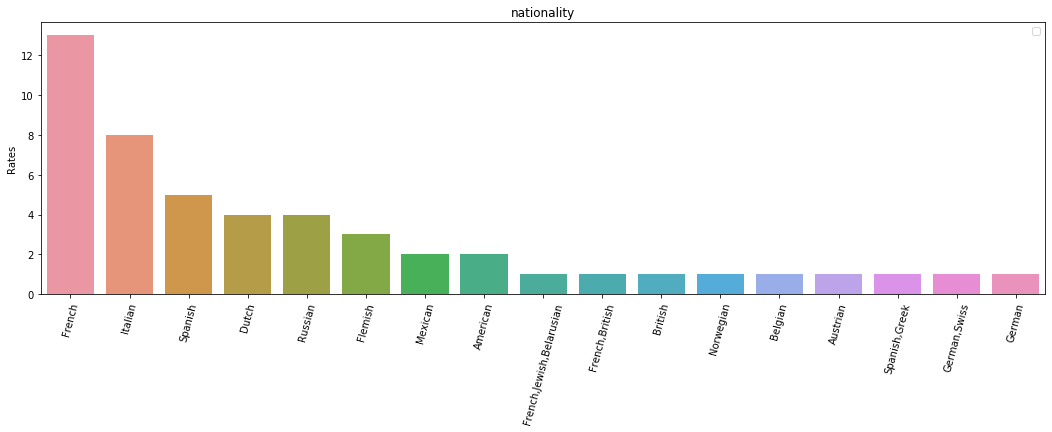

In [12]:
plt.figure(figsize=(18,5))

sns.barplot(x=artists['nationality'].value_counts().index,y=artists['nationality'].value_counts().values)
plt.title('nationality')
plt.xticks(rotation=75)
plt.ylabel('Rates')
plt.legend(loc=0)
plt.show()

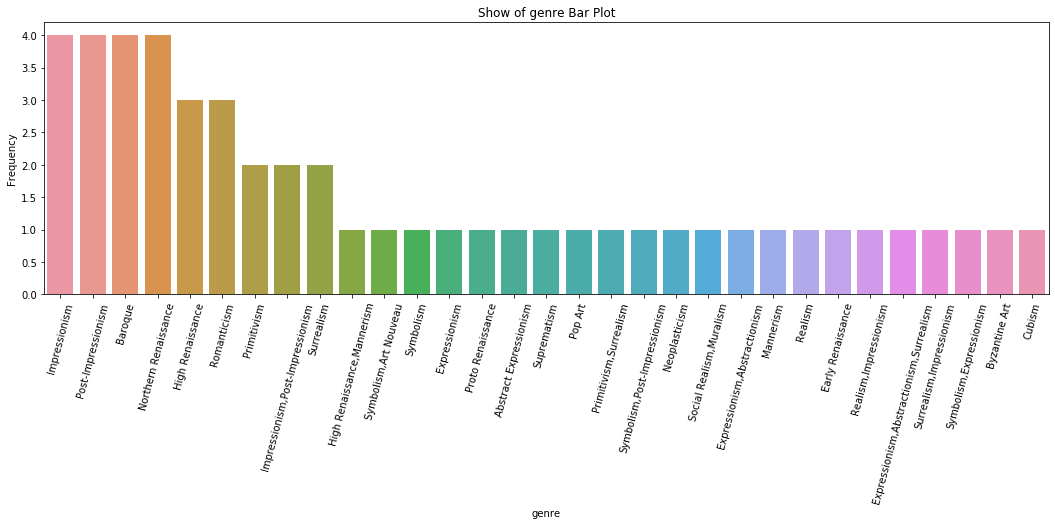

In [13]:
plt.figure(figsize=(18,5))
sns.barplot(x=artists['genre'].value_counts().index,
              y=artists['genre'].value_counts().values)
plt.xlabel('genre')
plt.xticks(rotation=75)
plt.ylabel('Frequency')
plt.title('Show of genre Bar Plot')
plt.show()

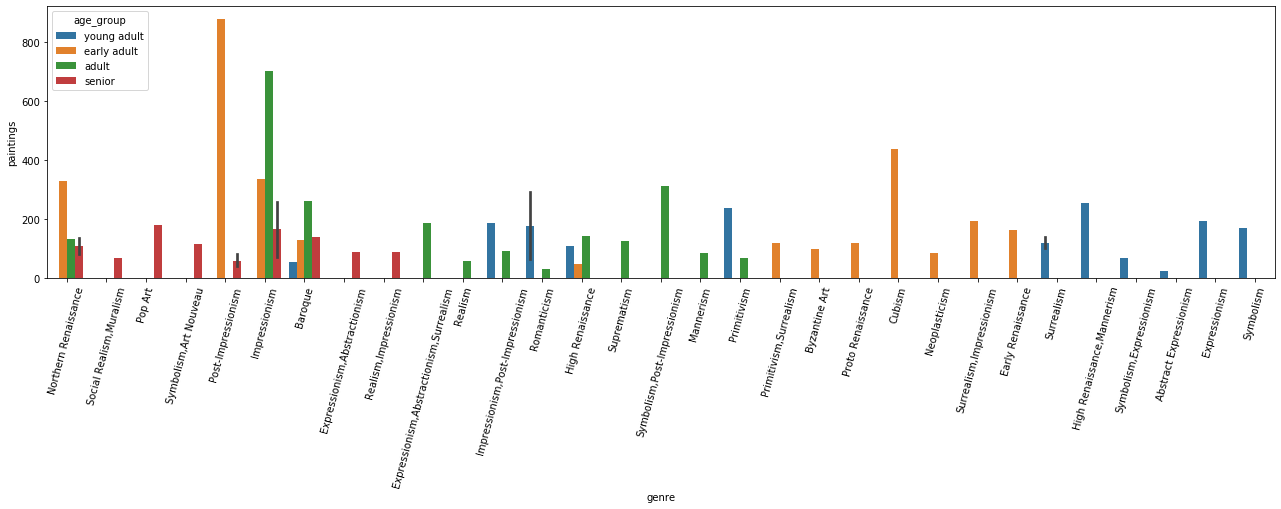

In [14]:
plt.figure(figsize=(22,5))
sns.barplot(x = "genre", y = "paintings", hue = "age_group", data = artists)
plt.xticks(rotation=75)
plt.show()

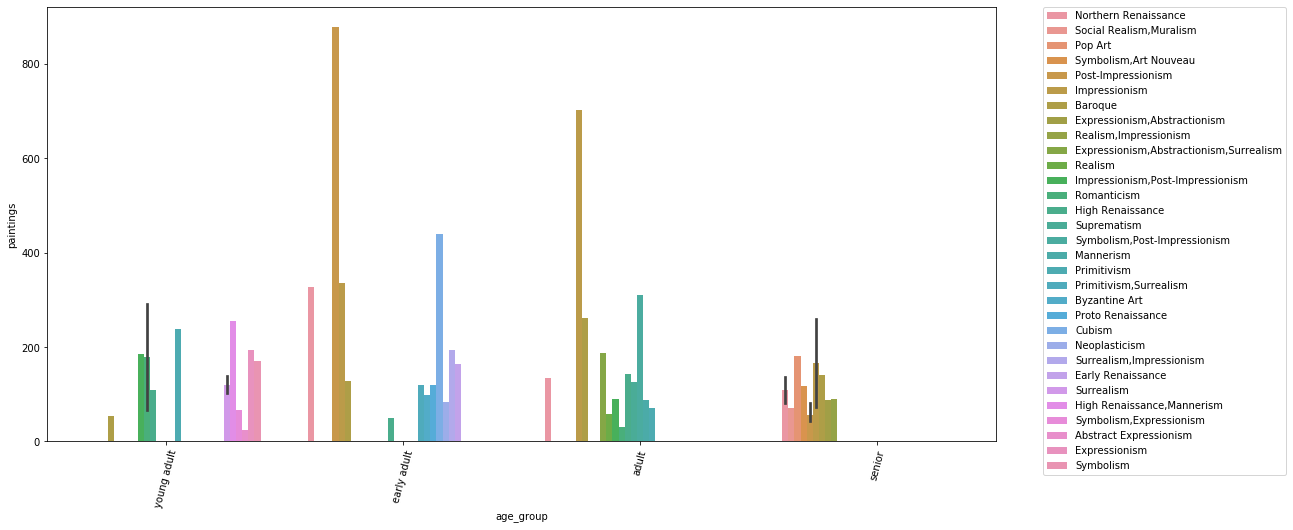

In [15]:
plt.figure(figsize=(17,8))
sns.barplot(x = "age_group", y = "paintings", hue = "genre", data = artists)
plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

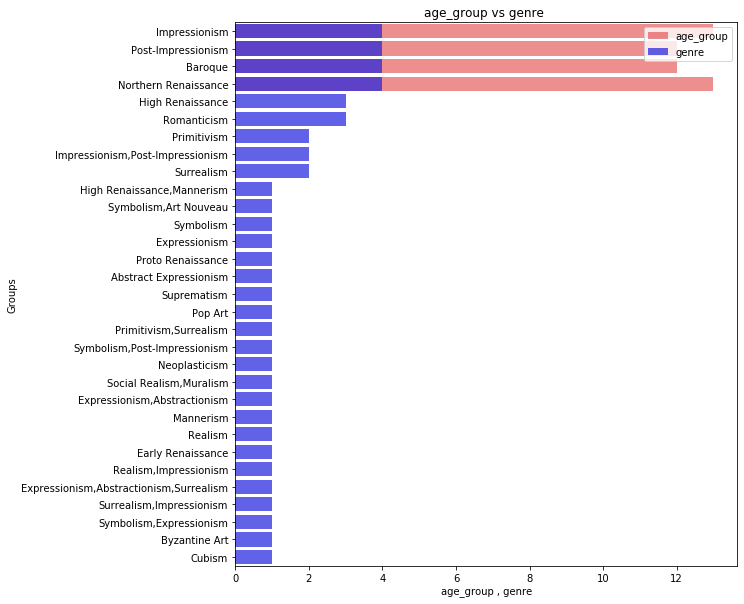

In [16]:
f,ax=plt.subplots(figsize=(9,10))
sns.barplot(x=artists['age_group'].value_counts().values,y=artists['age_group'].value_counts().index,alpha=0.5,color='red',label='age_group')
sns.barplot(x=artists['genre'].value_counts().values,y=artists['genre'].value_counts().index,color='blue',alpha=0.7,label='genre')
ax.legend(loc='upper right',frameon=True)
ax.set(xlabel='age_group , genre',ylabel='Groups',title="age_group vs genre ")
plt.show()

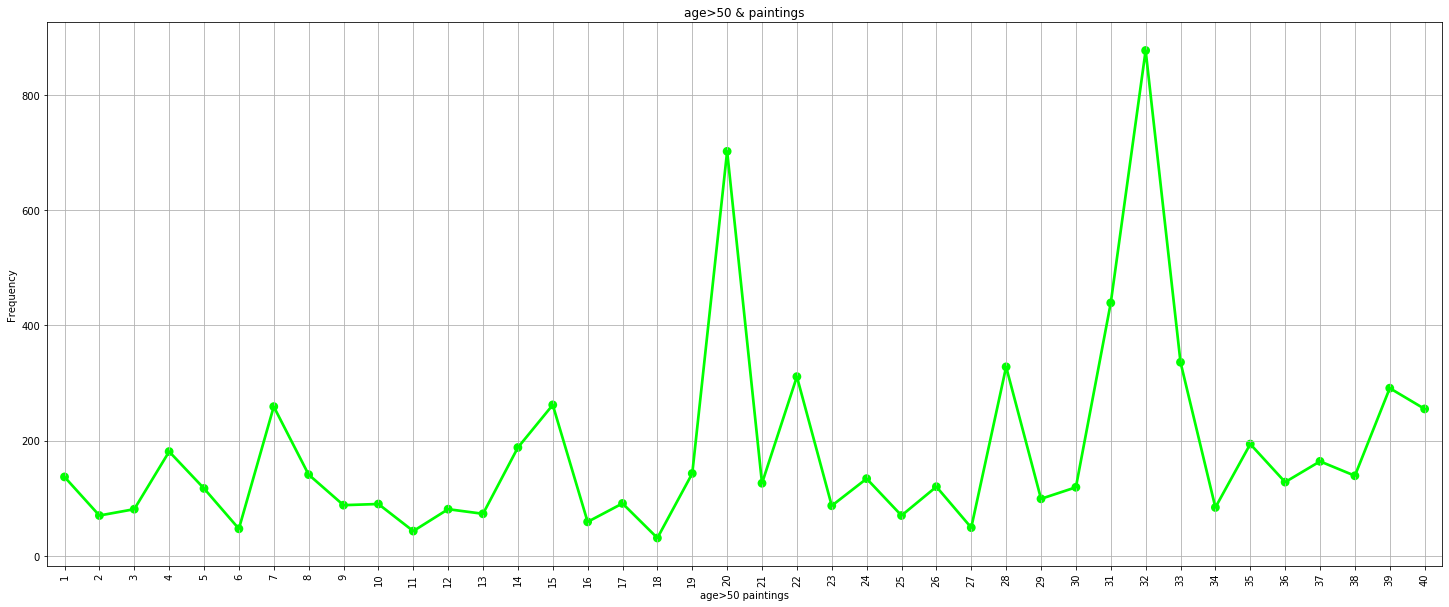

In [17]:
artists['age'].unique()
len(artists[(artists['age']>50)].paintings)
f,ax1=plt.subplots(figsize=(25,10))
sns.pointplot(x=np.arange(1,41),y=artists[(artists['age']>50)].paintings,color='lime',alpha=0.8)

plt.xlabel('age>50 paintings')
plt.ylabel('Frequency')
plt.title('age>50 & paintings')
plt.xticks(rotation=90)
plt.grid()
plt.show()

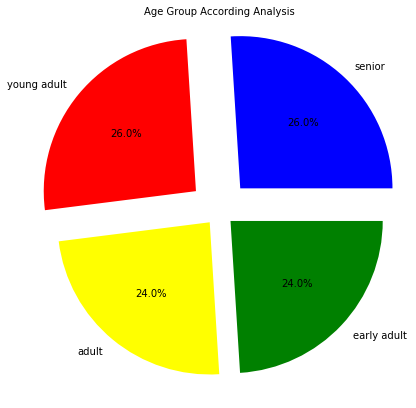

In [18]:
labels=artists['age_group'].value_counts().index
colors=['blue','red','yellow','green']
explode=[0.2,0.2,0.1,0.1,]
values=artists['age_group'].value_counts().values

#visualization
plt.figure(figsize=(7,7))
plt.pie(values,explode=explode,labels=labels,colors=colors,autopct='%1.1f%%')
plt.title('Age Group According Analysis',color='black',fontsize=10)
plt.show()

<Figure size 1080x504 with 0 Axes>

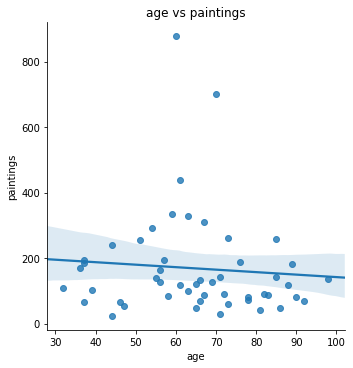

In [19]:
plt.figure(figsize=(15,7))
sns.lmplot(x='age',y='paintings',data=artists)
plt.xlabel('age')
plt.ylabel('paintings')
plt.title('age vs paintings')
plt.show()

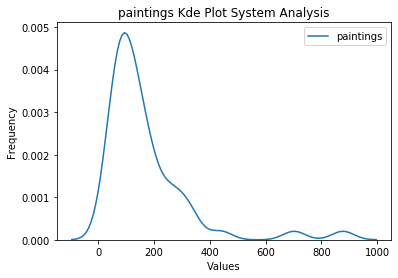

In [20]:
sns.kdeplot(artists['paintings'])
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('paintings Kde Plot System Analysis')
plt.show()

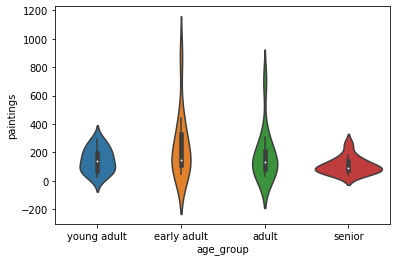

In [21]:
sns.violinplot(x=artists['age_group'],y=artists['paintings'])
plt.show()

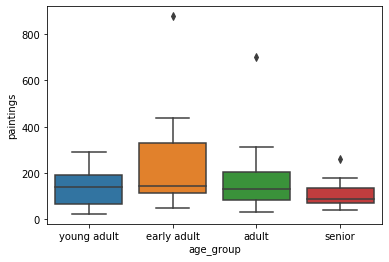

In [22]:
sns.boxplot(x=artists['age_group'],y=artists['paintings'])
plt.show()

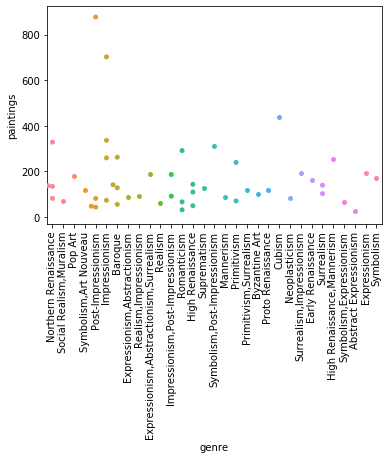

In [23]:
sns.swarmplot(x=artists['genre'],y=artists['paintings'])
plt.xticks(rotation=90)
plt.show()

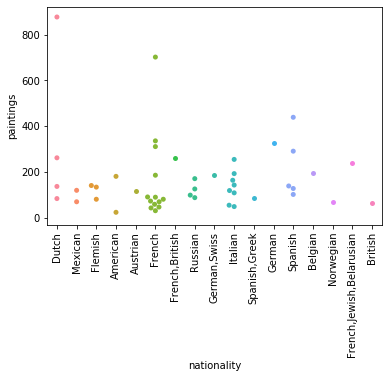

In [24]:
sns.swarmplot(x=artists['nationality'],y=artists['paintings'])
plt.xticks(rotation=90)
plt.show()

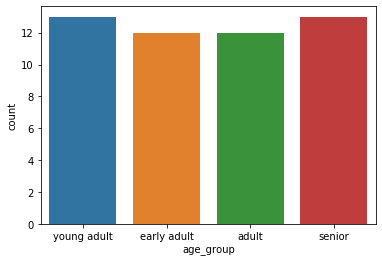

In [25]:
sns.countplot(artists['age_group'])
plt.show()

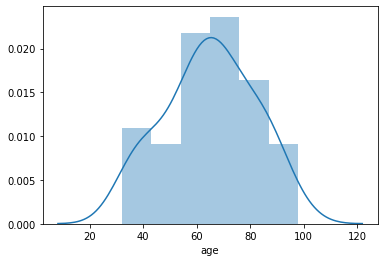

In [26]:
ax = sns.distplot(artists['age'])
plt.show()

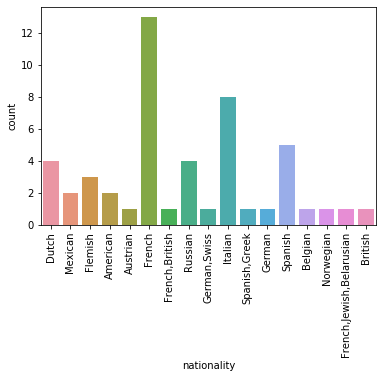

In [27]:
sns.countplot(artists['nationality'])
plt.xticks(rotation=90)
plt.show()

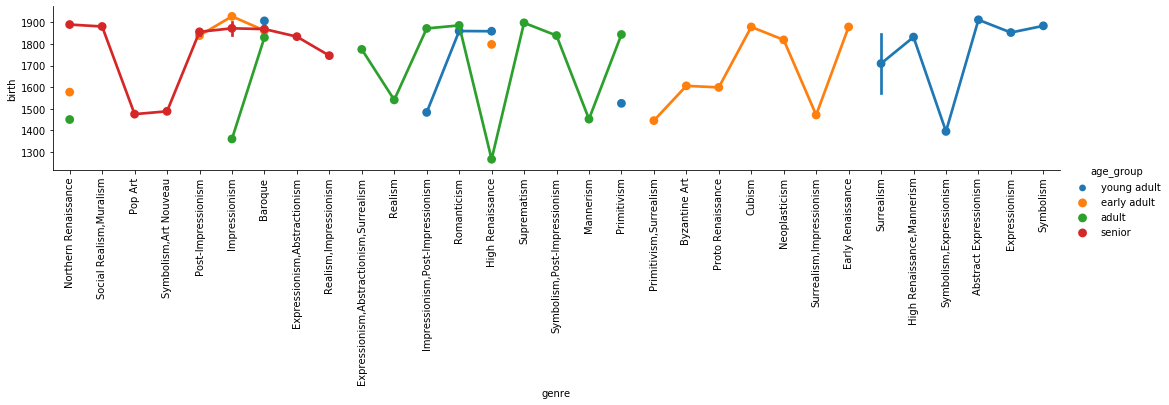

In [28]:
sns.factorplot(x="genre", y="birth", hue="age_group", data=artists,size=3, aspect=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=90)
plt.show()


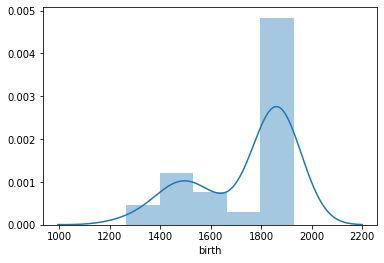

In [29]:
ax = sns.distplot(artists['birth'])
plt.show()

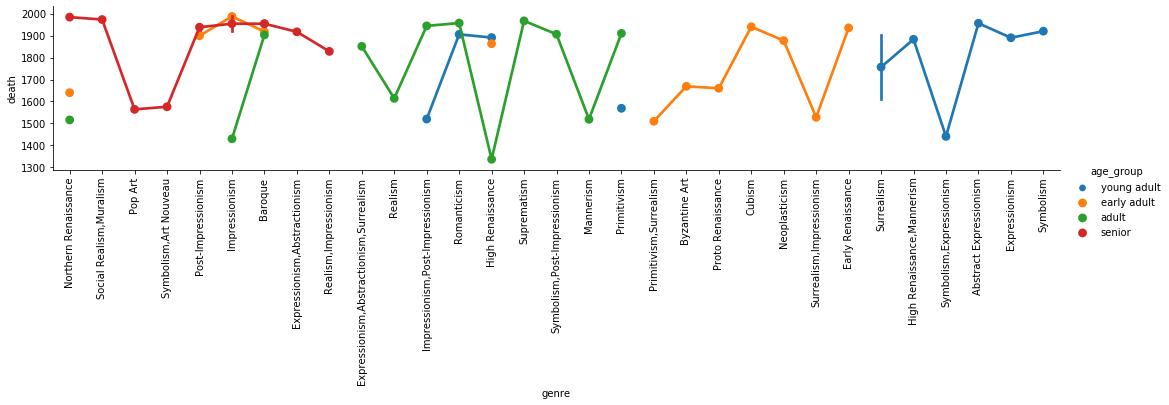

In [30]:
sns.factorplot(x="genre", y="death", hue="age_group", data=artists,size=3, aspect=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=90)
plt.show()

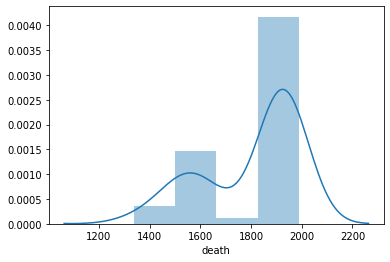

In [31]:
ax = sns.distplot(artists['death'])
plt.show()

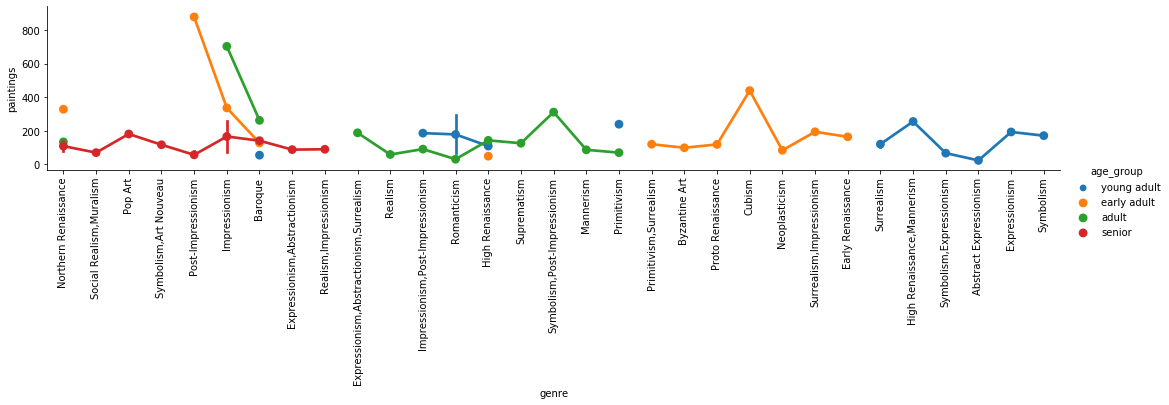

In [32]:
sns.factorplot(x="genre", y="paintings", hue="age_group", data=artists,size=3, aspect=5)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(rotation=90)
plt.show()

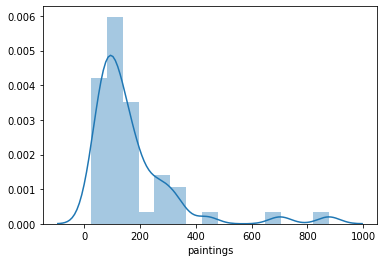

In [33]:
ax = sns.distplot(artists['paintings'])
plt.show()

In [34]:
# Explore images of top artists
images_dir = 'D:/DS5500/P2/Data/images/images'  #my files with this directory and folder you can change as u want to.
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> D:/DS5500/P2/Data/images/images\Vincent_van_Gogh
Found --> D:/DS5500/P2/Data/images/images\Edgar_Degas
Found --> D:/DS5500/P2/Data/images/images\Pablo_Picasso
Found --> D:/DS5500/P2/Data/images/images\Pierre-Auguste_Renoir
Found --> D:/DS5500/P2/Data/images/images\Albrecht_Dürer
Found --> D:/DS5500/P2/Data/images/images\Paul_Gauguin
Found --> D:/DS5500/P2/Data/images/images\Francisco_Goya
Found --> D:/DS5500/P2/Data/images/images\Rembrandt
Found --> D:/DS5500/P2/Data/images/images\Alfred_Sisley
Found --> D:/DS5500/P2/Data/images/images\Titian
Found --> D:/DS5500/P2/Data/images/images\Marc_Chagall
Found --> D:/DS5500/P2/Data/images/images\Rene_Magritte
Found --> D:/DS5500/P2/Data/images/images\Amedeo_Modigliani
Found --> D:/DS5500/P2/Data/images/images\Paul_Klee
Found --> D:/DS5500/P2/Data/images/images\Henri_Matisse
Found --> D:/DS5500/P2/Data/images/images\Andy_Warhol
Found --> D:/DS5500/P2/Data/images/images\Mikhail_Vrubel
Found --> D:/DS5500/P2/Data/images/images\Sandro_Bo

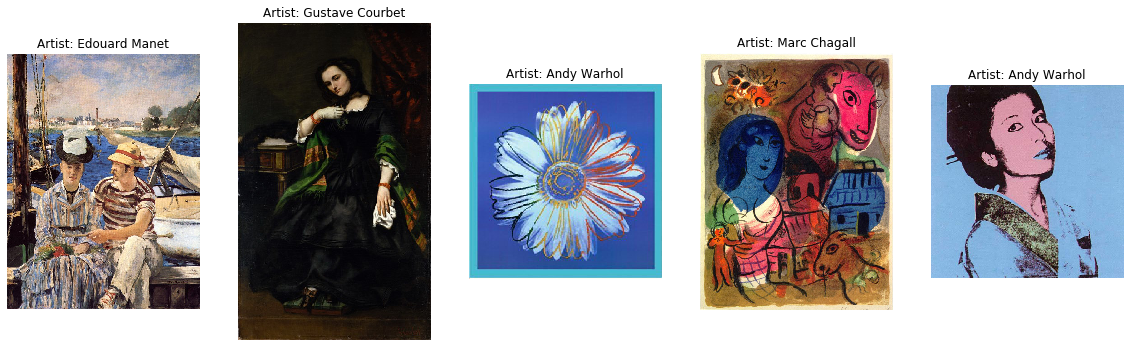

In [35]:
#https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/
# Print few random paintings
n = 5  # taking 5 random pic
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [36]:
# #cmyk convetion
# def rgb_to_cmyk(img_arr):
#     aaa = []

#     img_arr_min = (255 - img_arr)
#     K = np.min(img_arr_min, axis=2)

#     C_init = (img_arr_min[:, :, 0])
#     M_init = (img_arr_min[:, :, 1])
#     Y_init = (img_arr_min[:, :, 2])

#     C = C_init - K
#     M = M_init - K
#     Y = Y_init - K

#     aaa.append(C)
#     aaa.append(M)
#     aaa.append(Y)
#     aaa.append(K)
#     new_arr = np.array(aaa).transpose(1,2,0)
#     return new_arr

# def myFunc(image):
#     image = np.array(image)
#     converted_img = rgb_to_cmyk(image)
#     converted_img /= 255
#     return converted_img


In [37]:
#https://www.kaggle.com/supratimhaldar/
# Augment data
batch_size = 16
train_input_shape = (224, 224, 1)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    
                                                    batch_size=batch_size,
                                                    subset="training",
shuffle=True,
                                                    classes=artists_top_name.tolist(),
                                                    color_mode = "grayscale"
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
shuffle=True,
                                                    classes=artists_top_name.tolist(),
                                                    color_mode = "grayscale"
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 6779 images belonging to 50 classes.
Found 1667 images belonging to 50 classes.
Total number of batches = 423 and 104


In [38]:
train_input_shape[2:3]

(1,)

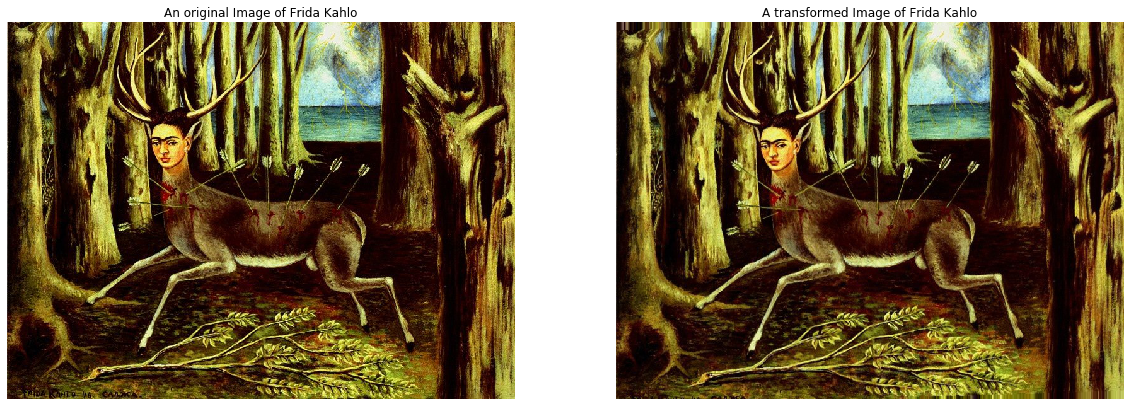

In [39]:
#https://www.kaggle.com/supratimhaldar/
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()


## Evaluation Functions

In [40]:
# Plot the training graph
def plot_training(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    


In [41]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))



In [62]:
from keras.preprocessing import *
def Prediction(model):


    n = 5
    fig, axes = plt.subplots(1, n, figsize=(25,10))

    for i in range(n):
        random_artist = random.choice(artists_top_name)
        random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
        random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

        test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))
        test_image = cv2.cvtColor(np.float32(test_image), cv2.COLOR_BGR2GRAY)

    # Predict artist
        test_image = image.img_to_array(test_image)
        
        test_image /= 255.
        test_image = np.expand_dims(test_image, axis=0)
        

        prediction = model.predict(test_image)
        prediction_probability = np.amax(prediction)
        prediction_idx = np.argmax(prediction)

        labels = train_generator.class_indices
        labels = dict((v,k) for k,v in labels.items())

    #print("Actual artist =", random_artist.replace('_', ' '))
    #print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
    #print("Prediction probability =", prediction_probability*100, "%")

        title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                    .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                            prediction_probability*100)

    # Print image
        axes[i].imshow(cv2.cvtColor(np.float32(plt.imread(random_image_file)), cv2.COLOR_BGR2GRAY))
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()

## Two layer CNN

In [124]:
def two_layer_CNN(input_shape):
    model = Sequential()
    model.add(Conv2D(input_shape = train_input_shape, filters = 32 , kernel_size = (3,3) ,padding='same', name= "conv_1"))    
    model.add(Conv2D(filters = 64 ,  kernel_size = (3,3), padding='same', name= "conv_12"))
    model.add(Activation('relu'))
    model.add(Flatten(input_shape=train_input_shape))
    #model.add(MaxPooling2D((4,4) , name = "max_pool_1"))
    model.add(Dense(n_classes, activation = 'softmax'))
    return model

In [125]:
twolayer_model = two_layer_CNN((train_input_shape))


sgd = SGD(lr=0.003, momentum=0.9, nesterov=True)

twolayer_model.compile(loss= 'categorical_crossentropy' ,
              optimizer = sgd,
               metrics=['accuracy'] )

twolayer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv_12 (Conv2D)             (None, 224, 224, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3211264)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                160563250 
Total params: 160,582,066
Trainable params: 160,582,066
Non-trainable params: 0
_________________________________________________________________


In [126]:
n_epoch = 50 #n_epoch :number of times training vect to update weight/ one complete iteration. 


early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, #I used ReduceLROnPlateau callback function when matri
                              verbose=1, mode='auto')
# Train the model - all layers
two_layer_history = twolayer_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1                           
                             )

Epoch 1/50
183/423 [===========>..................] - ETA: 0s - loss: 3.9156 - accuracy: 0.0000e+ - ETA: 6:03 - loss: 5.7516 - accuracy: 0.0312 - ETA: 7:36 - loss: 5.2342 - accuracy: 0.04 - ETA: 8:45 - loss: 4.8901 - accuracy: 0.06 - ETA: 9:21 - loss: 4.6697 - accuracy: 0.06 - ETA: 9:54 - loss: 4.5425 - accuracy: 0.05 - ETA: 10:14 - loss: 4.4900 - accuracy: 0.053 - ETA: 10:25 - loss: 4.4039 - accuracy: 0.054 - ETA: 10:34 - loss: 4.3564 - accuracy: 0.055 - ETA: 10:39 - loss: 4.3219 - accuracy: 0.050 - ETA: 10:42 - loss: 4.2619 - accuracy: 0.051 - ETA: 10:39 - loss: 4.2159 - accuracy: 0.057 - ETA: 10:40 - loss: 4.1727 - accuracy: 0.067 - ETA: 10:38 - loss: 4.1444 - accuracy: 0.067 - ETA: 10:39 - loss: 4.1382 - accuracy: 0.062 - ETA: 10:40 - loss: 4.1096 - accuracy: 0.066 - ETA: 10:41 - loss: 4.0807 - accuracy: 0.073 - ETA: 10:41 - loss: 4.0743 - accuracy: 0.072 - ETA: 10:41 - loss: 4.0569 - accuracy: 0.072 - ETA: 10:41 - loss: 4.0467 - accuracy: 0.068 - ETA: 10:41 - loss: 4.0311 - accura

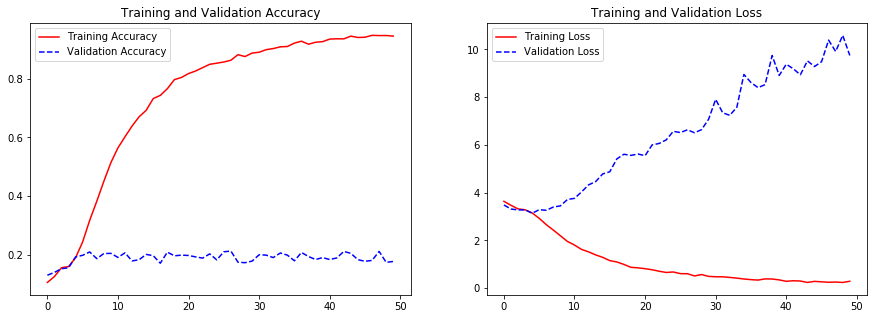

In [127]:
plot_training(two_layer_history)


In [128]:
two_layer_history.history['loss']

[3.633378744125366,
 3.465834140777588,
 3.3164243698120117,
 3.2784881591796875,
 3.1454689502716064,
 2.9204771518707275,
 2.655785322189331,
 2.428398847579956,
 2.190363645553589,
 1.9521348476409912,
 1.8009800910949707,
 1.6186423301696777,
 1.515248417854309,
 1.3885482549667358,
 1.2861744165420532,
 1.1479521989822388,
 1.092860221862793,
 0.9900627136230469,
 0.8684619069099426,
 0.8466808199882507,
 0.8104270696640015,
 0.766722559928894,
 0.7038566470146179,
 0.6528221964836121,
 0.6731879115104675,
 0.6037160754203796,
 0.6003696918487549,
 0.5076081156730652,
 0.5647539496421814,
 0.4894256889820099,
 0.47219398617744446,
 0.4712260663509369,
 0.4455093443393707,
 0.41521498560905457,
 0.37935319542884827,
 0.35292986035346985,
 0.3335321247577667,
 0.3830118775367737,
 0.3798322081565857,
 0.3412523865699768,
 0.28252241015434265,
 0.3055385947227478,
 0.2939644157886505,
 0.235895037651062,
 0.27994590997695923,
 0.26111164689064026,
 0.24279417097568512,
 0.25128382444

In [129]:
two_layer_history.history

{'loss': [3.633378744125366,
  3.465834140777588,
  3.3164243698120117,
  3.2784881591796875,
  3.1454689502716064,
  2.9204771518707275,
  2.655785322189331,
  2.428398847579956,
  2.190363645553589,
  1.9521348476409912,
  1.8009800910949707,
  1.6186423301696777,
  1.515248417854309,
  1.3885482549667358,
  1.2861744165420532,
  1.1479521989822388,
  1.092860221862793,
  0.9900627136230469,
  0.8684619069099426,
  0.8466808199882507,
  0.8104270696640015,
  0.766722559928894,
  0.7038566470146179,
  0.6528221964836121,
  0.6731879115104675,
  0.6037160754203796,
  0.6003696918487549,
  0.5076081156730652,
  0.5647539496421814,
  0.4894256889820099,
  0.47219398617744446,
  0.4712260663509369,
  0.4455093443393707,
  0.41521498560905457,
  0.37935319542884827,
  0.35292986035346985,
  0.3335321247577667,
  0.3830118775367737,
  0.3798322081565857,
  0.3412523865699768,
  0.28252241015434265,
  0.3055385947227478,
  0.2939644157886505,
  0.235895037651062,
  0.27994590997695923,
  0.2

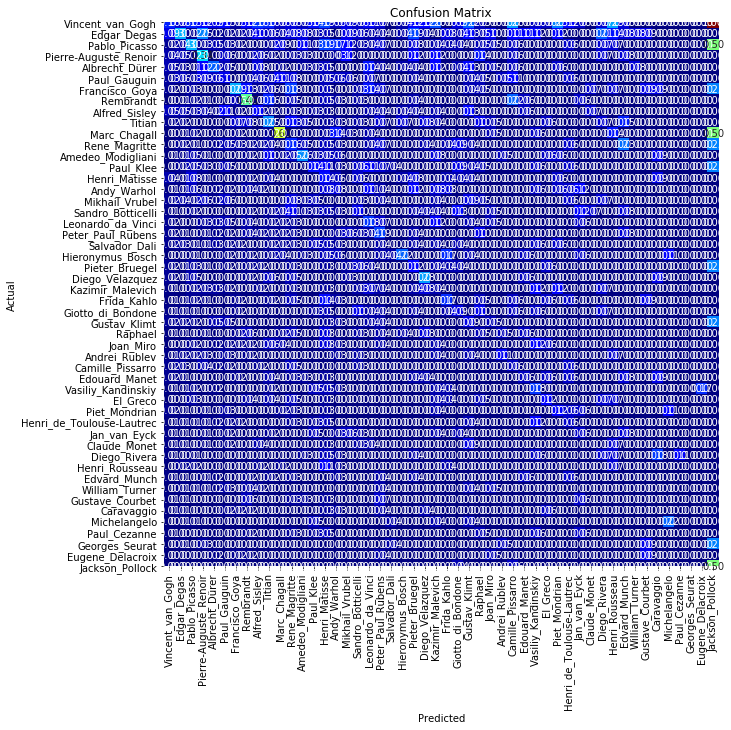

Classification Report:
                           precision    recall  f1-score   support

         Vincent_van_Gogh       0.18      0.16      0.17       174
              Edgar_Degas       0.28      0.30      0.29       140
            Pablo_Picasso       0.23      0.30      0.26        87
    Pierre-Auguste_Renoir       0.23      0.34      0.28        67
           Albrecht_Dürer       0.29      0.22      0.25        65
             Paul_Gauguin       0.09      0.10      0.09        62
           Francisco_Goya       0.41      0.29      0.34        58
                Rembrandt       0.32      0.46      0.38        52
            Alfred_Sisley       0.15      0.12      0.13        51
                   Titian       0.19      0.25      0.22        51
             Marc_Chagall       0.50      0.60      0.54        47
            Rene_Magritte       0.10      0.16      0.12        38
        Amedeo_Modigliani       0.32      0.26      0.29        38
                Paul_Klee       0.17  

In [130]:
showClassficationReport_Generator(twolayer_model, valid_generator, STEP_SIZE_VALID)

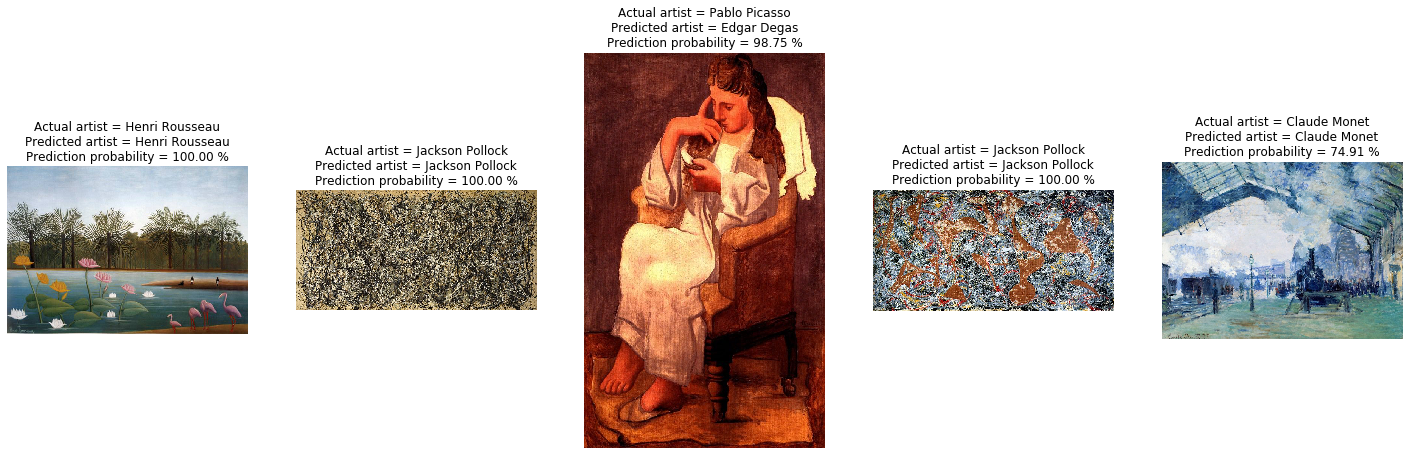

In [131]:
Prediction(twolayer_model)

## VGG - 16

In [43]:
def CNN_VGG_vgg_16(input_shape):
    vgg_16 = Sequential()

    vgg_16.add(Conv2D(input_shape = input_shape, filters = 32 , kernel_size = (3,3) ,padding='same', name= "conv_1"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(Conv2D(filters = 64 ,  kernel_size = (3,3), padding='same', name= "conv_12"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(MaxPooling2D((2,2) , name = "max_pool_1"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_1") )


    vgg_16.add(Conv2D(filters = 64 ,  kernel_size = (3,3), padding='same', name= "conv_21"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(Conv2D(filters = 64 ,  kernel_size = (3,3), padding='same', name= "conv_22"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(MaxPooling2D((2,2) ,name = "max_pool_2"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_2") )


    vgg_16.add(Conv2D(filters = 128 ,  kernel_size = (3,3), padding='same', name= "conv_3"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(MaxPooling2D((2,2) , name = "max_pool_3"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_3") )
    
    


    vgg_16.add(Conv2D(filters = 256 ,  kernel_size = (3,3),padding='same', name= "conv_4"))
    vgg_16.add(Activation('relu'))
    vgg_16.add(MaxPooling2D((2,2) , name = "max_pool_4"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_4") )
    
    


    vgg_16.add(Conv2D(filters = 256 ,  kernel_size = (3,3), strides=(1,1), activation = 'relu' ,padding='same', name= "conv_5"))
    vgg_16.add(MaxPooling2D((2,2) , name = "max_pool_5"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_5") )
    
    

    vgg_16.add(Conv2D(filters = 512 ,  kernel_size = (3,3), strides=(1,1), activation = 'relu' ,padding='same', name= "conv_6"))
    vgg_16.add(MaxPooling2D((2,2) , name = "max_pool_6"))
    vgg_16.add(BatchNormalization(axis = 3 , name ="bn_6") )
    

    vgg_16.add(Flatten())

    vgg_16.add(Dense(512 , name = 'Fully_connected_11' ))
    vgg_16.add(Activation('relu'))
    # vgg_16.add(Dropout(rate = 0.2) )


    vgg_16.add(Dense(n_classes, activation= 'softmax', name = 'softmax_output_11' ))

    return vgg_16

In [44]:
dropout_rate = 0.2


cnn_vgg_vgg_16 = CNN_VGG_vgg_16(train_input_shape)

#adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.99, amsgrad=False)
cnn_vgg_sgd = SGD(lr=0.003, momentum=0.9, nesterov=True)
#rms_prop = RMSprop(lr=0.001, rho =0.9)
cnn_vgg_vgg_16.compile(loss= 'categorical_crossentropy' ,
              optimizer = cnn_vgg_sgd,
               metrics=['accuracy'] )

cnn_vgg_vgg_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv_12 (Conv2D)             (None, 224, 224, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 112, 112, 64)      0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 112, 112, 64)      256       
_________________________________________________________________
conv_21 (Conv2D)             (None, 112, 112, 64)      3

In [45]:
n_epoch = 50 #n_epoch :number of times training vect to update weight/ one complete iteration. 


early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, #I used ReduceLROnPlateau callback function when matri
                              verbose=1, mode='auto')
# Train the model - all layers
vgg16_history = cnn_vgg_vgg_16.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1                           
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
178/423 [===========>..................] - ETA: 0s - loss: 3.9448 - accuracy: 0.06 - ETA: 8:43 - loss: 3.9023 - accuracy: 0.06 - ETA: 11:42 - loss: 4.0937 - accuracy: 0.041 - ETA: 13:09 - loss: 4.1524 - accuracy: 0.031 - ETA: 14:03 - loss: 4.0243 - accuracy: 0.075 - ETA: 14:35 - loss: 4.1291 - accuracy: 0.072 - ETA: 14:57 - loss: 4.2163 - accuracy: 0.071 - ETA: 15:13 - loss: 4.2199 - accuracy: 0.085 - ETA: 15:25 - loss: 4.2943 - accuracy: 0.090 - ETA: 15:35 - loss: 4.2329 - accuracy: 0.093 - ETA: 15:41 - loss: 4.3099 - accuracy: 0.085 - ETA: 15:47 - loss: 4.3132 - accuracy: 0.078 - ETA: 15:51 - loss: 4.3460 - accuracy: 0.076 - ETA: 15:55 - loss: 4.3371 - accuracy: 0.080 - ETA: 15:58 - loss: 4.2880 - accuracy: 0.079 - ETA: 16:00 - loss: 4.2917 - accuracy: 0.074 - ETA: 16:02 - loss: 4.2412 - accuracy: 0.073 - ETA: 16:03 - loss: 4.2661 - accuracy: 0.072 - ETA: 16:03 - loss: 4.2603 - accuracy: 0.075 - ET

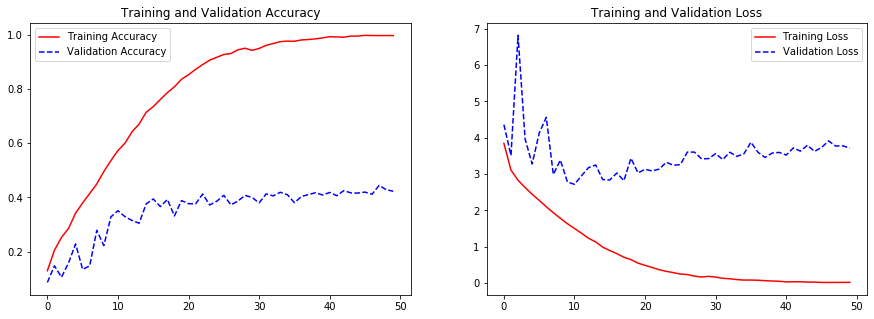

In [46]:
plot_training(vgg16_history)





In [47]:
vgg16_history.history['loss']

[3.84379243850708,
 3.1086268424987793,
 2.8292434215545654,
 2.630628824234009,
 2.4434118270874023,
 2.274379014968872,
 2.1006109714508057,
 1.9368404150009155,
 1.7831209897994995,
 1.6320359706878662,
 1.5019222497940063,
 1.3705403804779053,
 1.231320858001709,
 1.1331290006637573,
 0.9874209761619568,
 0.8955423831939697,
 0.8091906905174255,
 0.710681676864624,
 0.6451807618141174,
 0.5476614236831665,
 0.4853856861591339,
 0.42819511890411377,
 0.3668668270111084,
 0.32194989919662476,
 0.28687888383865356,
 0.24781842529773712,
 0.23476693034172058,
 0.18984420597553253,
 0.16493374109268188,
 0.18449246883392334,
 0.1628931313753128,
 0.1307292878627777,
 0.1175956204533577,
 0.0957697257399559,
 0.08114545047283173,
 0.08279766887426376,
 0.07670965790748596,
 0.06530611217021942,
 0.05464039742946625,
 0.04927018657326698,
 0.031849414110183716,
 0.034260544925928116,
 0.0355546772480011,
 0.026293262839317322,
 0.02591889165341854,
 0.016728265210986137,
 0.01629229448735

In [48]:
vgg16_history.history

{'loss': [3.84379243850708,
  3.1086268424987793,
  2.8292434215545654,
  2.630628824234009,
  2.4434118270874023,
  2.274379014968872,
  2.1006109714508057,
  1.9368404150009155,
  1.7831209897994995,
  1.6320359706878662,
  1.5019222497940063,
  1.3705403804779053,
  1.231320858001709,
  1.1331290006637573,
  0.9874209761619568,
  0.8955423831939697,
  0.8091906905174255,
  0.710681676864624,
  0.6451807618141174,
  0.5476614236831665,
  0.4853856861591339,
  0.42819511890411377,
  0.3668668270111084,
  0.32194989919662476,
  0.28687888383865356,
  0.24781842529773712,
  0.23476693034172058,
  0.18984420597553253,
  0.16493374109268188,
  0.18449246883392334,
  0.1628931313753128,
  0.1307292878627777,
  0.1175956204533577,
  0.0957697257399559,
  0.08114545047283173,
  0.08279766887426376,
  0.07670965790748596,
  0.06530611217021942,
  0.05464039742946625,
  0.04927018657326698,
  0.031849414110183716,
  0.034260544925928116,
  0.0355546772480011,
  0.026293262839317322,
  0.025918

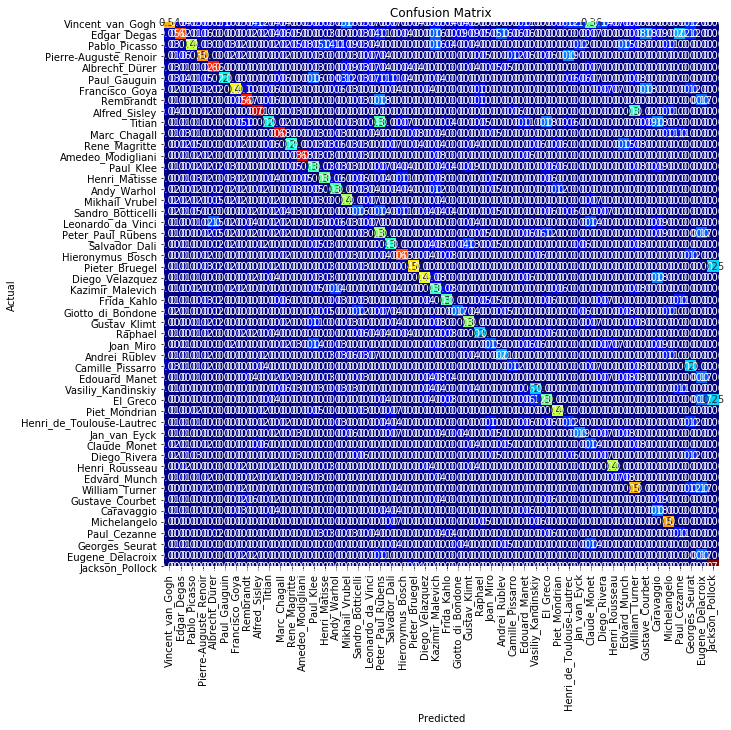

Classification Report:
                           precision    recall  f1-score   support

         Vincent_van_Gogh       0.51      0.54      0.53       175
              Edgar_Degas       0.57      0.62      0.59       140
            Pablo_Picasso       0.43      0.44      0.43        87
    Pierre-Auguste_Renoir       0.52      0.56      0.54        66
           Albrecht_Dürer       0.60      0.66      0.63        65
             Paul_Gauguin       0.45      0.27      0.34        62
           Francisco_Goya       0.56      0.48      0.52        58
                Rembrandt       0.57      0.67      0.61        51
            Alfred_Sisley       0.68      0.71      0.69        51
                   Titian       0.29      0.27      0.28        51
             Marc_Chagall       0.55      0.68      0.61        47
            Rene_Magritte       0.37      0.29      0.32        38
        Amedeo_Modigliani       0.74      0.68      0.71        38
                Paul_Klee       0.24  

In [49]:
showClassficationReport_Generator(cnn_vgg_vgg_16, valid_generator, STEP_SIZE_VALID)

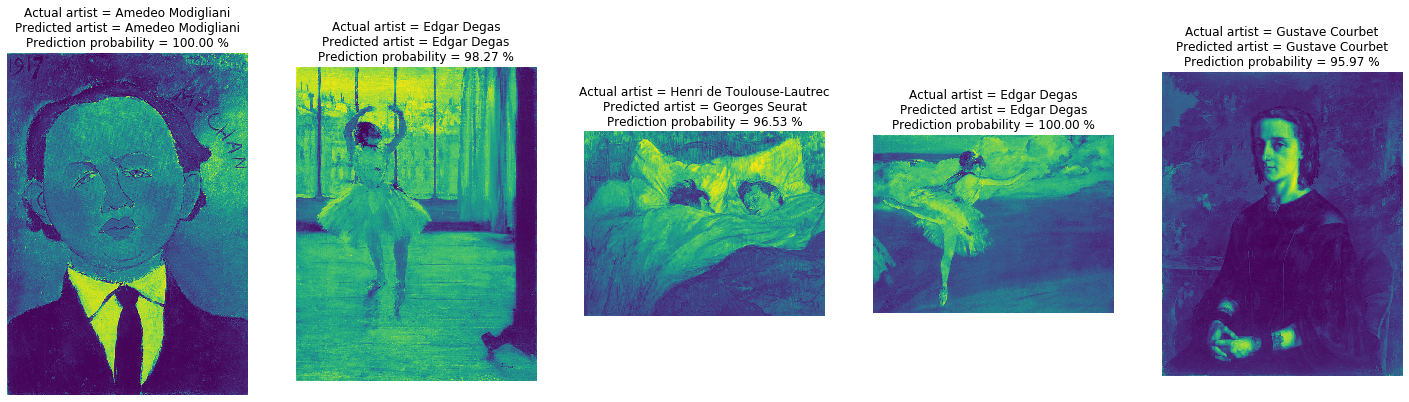

In [64]:
Prediction(cnn_vgg_vgg_16)

## Inceptions

In [51]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

In [52]:
input_tensor = Input(shape=(224, 224, 1))  # this assumes K.image_data_format() == 'channels_last'

inception_model = InceptionV3(input_tensor=input_tensor, weights=None, include_top=True, classes = n_classes )
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [53]:
inception_adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, amsgrad=False)
inception_sgd = SGD(lr=0.003, momentum=0.9, nesterov=True)

inception_model.compile(loss= 'categorical_crossentropy' ,
              optimizer = inception_sgd,
               metrics=['accuracy'] )

In [54]:
n_epoch = 50 #n_epoch :number of times training vect to update weight/ one complete iteration. 


early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, #I used ReduceLROnPlateau callback function when matri
                              verbose=1, mode='auto')
# Train the model - all layers
inception_history = inception_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1                           
                             )

Epoch 1/50
177/423 [===========>..................] - ETA: 0s - loss: 3.9739 - accuracy: 0.0000e+ - ETA: 13:30 - loss: 4.0089 - accuracy: 0.0312 - ETA: 18:05 - loss: 4.0393 - accuracy: 0.020 - ETA: 20:18 - loss: 3.9199 - accuracy: 0.031 - ETA: 21:39 - loss: 3.8730 - accuracy: 0.025 - ETA: 22:15 - loss: 3.9911 - accuracy: 0.031 - ETA: 22:40 - loss: 4.0472 - accuracy: 0.044 - ETA: 22:57 - loss: 3.9953 - accuracy: 0.054 - ETA: 23:07 - loss: 3.9737 - accuracy: 0.055 - ETA: 23:15 - loss: 3.9386 - accuracy: 0.062 - ETA: 23:20 - loss: 3.9231 - accuracy: 0.073 - ETA: 23:24 - loss: 3.8813 - accuracy: 0.093 - ETA: 23:28 - loss: 3.8673 - accuracy: 0.091 - ETA: 23:29 - loss: 3.8599 - accuracy: 0.098 - ETA: 23:32 - loss: 3.8882 - accuracy: 0.095 - ETA: 23:34 - loss: 3.8732 - accuracy: 0.097 - ETA: 23:37 - loss: 3.8555 - accuracy: 0.095 - ETA: 23:36 - loss: 3.8650 - accuracy: 0.093 - ETA: 23:36 - loss: 3.8593 - accuracy: 0.098 - ETA: 23:35 - loss: 3.8748 - accuracy: 0.096 - ETA: 23:36 - loss: 3.8552

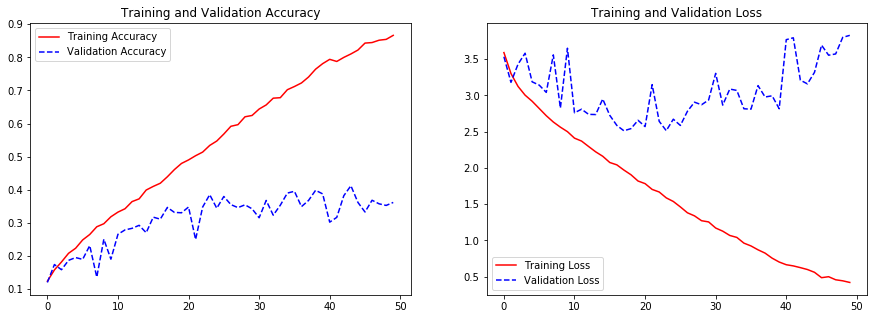

In [55]:
plot_training(inception_history)

In [56]:
inception_history.history['loss']

[3.5892832279205322,
 3.3004305362701416,
 3.123140811920166,
 3.00264048576355,
 2.918412923812866,
 2.819035530090332,
 2.7192800045013428,
 2.6322412490844727,
 2.5613627433776855,
 2.499375581741333,
 2.4098260402679443,
 2.3695929050445557,
 2.294590711593628,
 2.221311092376709,
 2.160181760787964,
 2.0741164684295654,
 2.041686534881592,
 1.9699009656906128,
 1.905365228652954,
 1.8190315961837769,
 1.7830078601837158,
 1.7031118869781494,
 1.6676093339920044,
 1.58662748336792,
 1.5369842052459717,
 1.461856722831726,
 1.38096284866333,
 1.3386083841323853,
 1.271708607673645,
 1.255152702331543,
 1.171012043952942,
 1.1276817321777344,
 1.0684722661972046,
 1.041448950767517,
 0.9628689885139465,
 0.9241471886634827,
 0.870675802230835,
 0.8250468969345093,
 0.7554583549499512,
 0.7021723985671997,
 0.6650363802909851,
 0.6488334536552429,
 0.6249682307243347,
 0.598939836025238,
 0.560641348361969,
 0.48644906282424927,
 0.4999077320098877,
 0.4576371908187866,
 0.44324776530

In [57]:
inception_history.history

{'loss': [3.5892832279205322,
  3.3004305362701416,
  3.123140811920166,
  3.00264048576355,
  2.918412923812866,
  2.819035530090332,
  2.7192800045013428,
  2.6322412490844727,
  2.5613627433776855,
  2.499375581741333,
  2.4098260402679443,
  2.3695929050445557,
  2.294590711593628,
  2.221311092376709,
  2.160181760787964,
  2.0741164684295654,
  2.041686534881592,
  1.9699009656906128,
  1.905365228652954,
  1.8190315961837769,
  1.7830078601837158,
  1.7031118869781494,
  1.6676093339920044,
  1.58662748336792,
  1.5369842052459717,
  1.461856722831726,
  1.38096284866333,
  1.3386083841323853,
  1.271708607673645,
  1.255152702331543,
  1.171012043952942,
  1.1276817321777344,
  1.0684722661972046,
  1.041448950767517,
  0.9628689885139465,
  0.9241471886634827,
  0.870675802230835,
  0.8250468969345093,
  0.7554583549499512,
  0.7021723985671997,
  0.6650363802909851,
  0.6488334536552429,
  0.6249682307243347,
  0.598939836025238,
  0.560641348361969,
  0.48644906282424927,
  

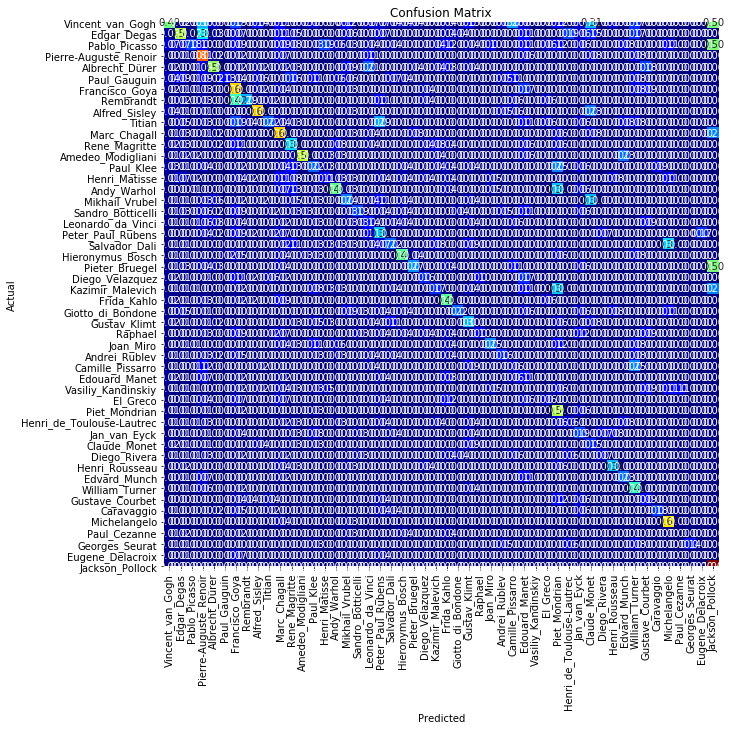

Classification Report:
                           precision    recall  f1-score   support

         Vincent_van_Gogh       0.49      0.49      0.49       174
              Edgar_Degas       0.41      0.57      0.47       138
            Pablo_Picasso       0.48      0.18      0.27        87
    Pierre-Auguste_Renoir       0.29      0.81      0.43        67
           Albrecht_Dürer       0.57      0.53      0.55        64
             Paul_Gauguin       0.89      0.13      0.23        62
           Francisco_Goya       0.24      0.68      0.36        57
                Rembrandt       0.65      0.29      0.41        51
            Alfred_Sisley       0.67      0.69      0.68        51
                   Titian       0.52      0.22      0.31        50
             Marc_Chagall       0.33      0.69      0.44        45
            Rene_Magritte       0.24      0.34      0.28        38
        Amedeo_Modigliani       0.88      0.58      0.70        38
                Paul_Klee       0.21  

In [58]:
showClassficationReport_Generator(inception_model, valid_generator, STEP_SIZE_VALID)

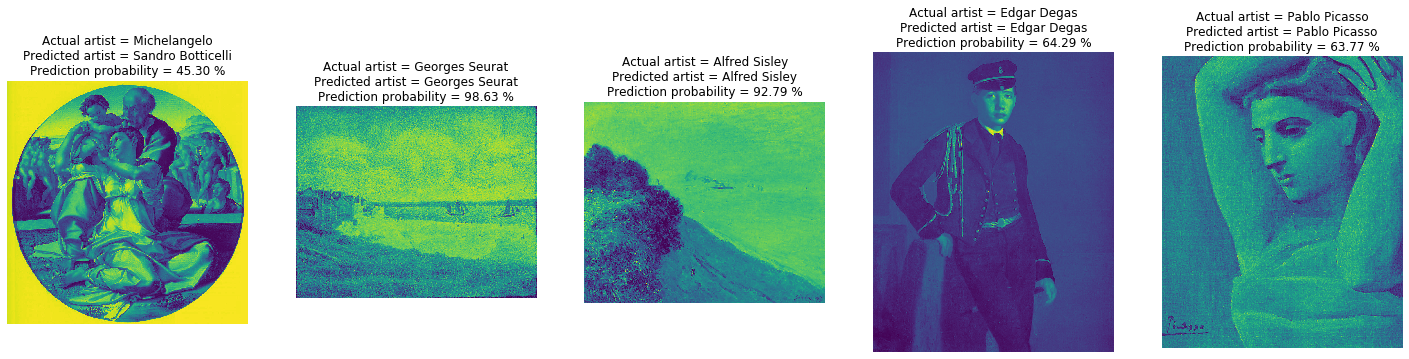

In [63]:
Prediction(inception_model)